# 5. Simulation model

## Step 1: Import Libraries and Initialize Parameters

### We first import necessary Python libraries and define simulation parameters, including the number of gates, crews, arrival rate, service time, and simulation duration.

In [8]:
!pip install simpy
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

# Simulation parameters
NUM_GATES = 2
NUM_CREWS = 3
ARRIVAL_RATE = 12   # flights per day
SERVICE_TIME_MEAN = 60  # in minutes
SIM_TIME = 30 * 24 * 60  # 30 days in minutes

## Step 2: Define Entities and Resources

### The key entities in the system are flights, and the main resources are gates and ground crews. Each flight requires access to both resources to be processed.

In [12]:
def flight(env, name, gate, crew):
    global wait_times, service_times, flight_count

    arrival_time = env.now

    with gate.request() as g, crew.request() as c:
        yield g & c
        wait = env.now - arrival_time
        wait_times.append(wait)

        service_time = np.random.exponential(SERVICE_TIME_MEAN)
        service_times.append(service_time)

        yield env.timeout(service_time)
        flight_count += 1

## Step 3: Arrival and Simulation Logic

### Flights arrive randomly based on an exponential inter-arrival time. Each arrival creates a flight process that requests resources and undergoes service.

In [16]:
def flight_arrival(env, gate, crew):
    while True:
        interarrival = np.random.exponential(24*60 / ARRIVAL_RATE)
        yield env.timeout(interarrival)
        env.process(flight(env, f'Flight {env.now:.1f}', gate, crew))

## Step 4: Run the Simulation

### The environment and resources are initialized, and the simulation is executed over the predefined time horizon.

In [20]:
# Initialize metrics
wait_times = []
service_times = []
flight_count = 0

# Set up environment
env = simpy.Environment()
gate_resource = simpy.Resource(env, capacity=NUM_GATES)
crew_resource = simpy.Resource(env, capacity=NUM_CREWS)

# Start simulation
env.process(flight_arrival(env, gate_resource, crew_resource))
env.run(until=SIM_TIME)

## Step 5: Performance Metrics and Output

### After simulation execution, we compute key performance indicators such as total flights processed, average wait time, and average service time.

In [24]:
print(f"Total flights served: {flight_count}")
print(f"Average wait time: {np.mean(wait_times):.2f} minutes")
print(f"Average service time: {np.mean(service_times):.2f} minutes")

Total flights served: 367
Average wait time: 2.36 minutes
Average service time: 62.59 minutes


## Step 6: Visualization of Results

### Histogram plots are used to analyze the distribution of waiting times and service times.

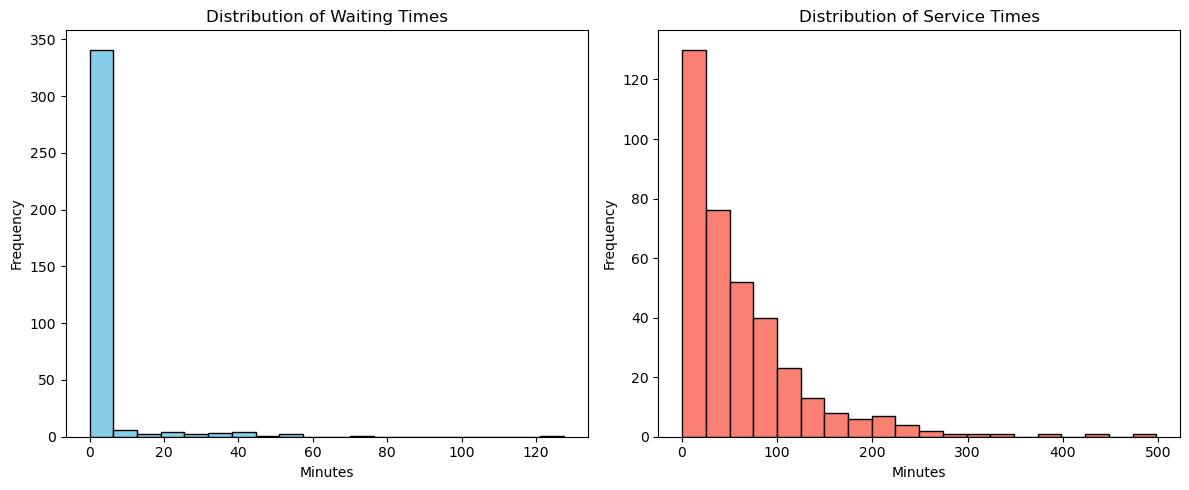

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(wait_times, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Waiting Times")
plt.xlabel("Minutes")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(service_times, bins=20, color='salmon', edgecolor='black')
plt.title("Distribution of Service Times")
plt.xlabel("Minutes")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Step 7: Function for Scenario Comparison

### To enable easy scenario analysis in later sections (E), the model can be wrapped into a function for reusability.

In [32]:
def run_simulation(gates, crews, arrival_rate, sim_time=30*24*60):
    global wait_times, service_times, flight_count
    wait_times = []
    service_times = []
    flight_count = 0

    env = simpy.Environment()
    gate_res = simpy.Resource(env, capacity=gates)
    crew_res = simpy.Resource(env, capacity=crews)

    def flight_arrival(env, gate, crew):
        while True:
            interarrival = np.random.exponential(24*60 / arrival_rate)
            yield env.timeout(interarrival)
            env.process(flight(env, f'Flight {env.now:.1f}', gate, crew))

    env.process(flight_arrival(env, gate_res, crew_res))
    env.run(until=sim_time)

    return {
        'avg_wait': np.mean(wait_times),
        'avg_service': np.mean(service_times),
        'count': flight_count
    }